In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

In [2]:
file_paths = [
    "/Users/mayarios/Desktop/Spring 25/class_data_2023.csv",
    "/Users/mayarios/Desktop/Spring 25/class_data_2024.csv",
    "/Users/mayarios/Desktop/Spring 25/class_data_2025.csv"
]

dataframes = [pd.read_csv(path, dtype=str) for path in file_paths]
full_dataframe = pd.concat(dataframes, ignore_index=True)
full_dataframe.columns = full_dataframe.columns.str.strip().str.lower()


In [3]:
unique_natures = pd.Series(full_dataframe["nature"].dropna().unique())
cahoots_natures = unique_natures[unique_natures.str.contains("CAHOOTS", case=False)]
base_natures = cahoots_natures.str.replace(r",\s*CAHOOTS", "", regex=True)
matching_base = base_natures[base_natures.isin(unique_natures)]
filter_list = pd.concat([matching_base, 
                         matching_base + ", CAHOOTS"]).tolist()
filtered_df = full_dataframe[full_dataframe["nature"].isin(filter_list)]
filtered_df.columns
filtered_df.head()


,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,secs_to_arrv,secs_to_close,disp,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived
13,2023,LAW,23000038,2023-01-01 00:29:08.000,NaN,W911,DISORDERLY SUBJECT,RSLV,RESOLVED,578.0,1017.0,1047,1,1,EP01,3,,4E36,3,2
43,2023,OTHR,23000118,2023-01-01 02:19:08.000,NaN,PHONE,"TRANSPORT, CAHOOTS",DIS,DISREGARD,NaN,NaN,7712,0,0,EP07,7,,CAHOOT,0,0
73,2023,OTHR,23000198,2023-01-01 05:38:50.000,NaN,E911,"SUICIDAL SUBJECT, CAHOOTS",ASST,ASSISTED,933.0,2137.0,3990,1,1,EP01,5,,CAHOOT,1,1
74,2023,LAW,23000204,2023-01-01 06:09:33.000,NaN,W911,DISORDERLY SUBJECT,ADVI,ADVISED,88.0,287.0,677,1,1,EP05,3,,6E55,3,3
79,2023,LAW,23000219,2023-01-01 07:12:48.000,2300009,W911,DISORDERLY SUBJECT,ARR,ARREST,262.0,262.0,12434,1,1,EP05,3,,1U44,4,4


In [4]:
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests


full_dataframe["calltime"] = pd.to_datetime(full_dataframe["calltime"])
before_start = "2023-08-01"
before_end = "2024-03-31"  

after_start = "2024-08-01"
after_end = "2025-03-31"

before_df = full_dataframe[
    (full_dataframe["calltime"] >= before_start) & (full_dataframe["calltime"] <= before_end)
]

after_df = full_dataframe[
    (full_dataframe["calltime"] >= after_start) & (full_dataframe["calltime"] <= after_end)
]

cahoots_natures = full_dataframe["nature"].dropna().unique()
cahoots_natures = [n for n in cahoots_natures if "CAHOOTS" in n]

base_natures = [n.replace(", CAHOOTS", "").strip() for n in cahoots_natures]

all_natures = set(full_dataframe["nature"].dropna().unique())
shared_natures = [n for n in base_natures if n in all_natures]

def count_cases(nature, df):
    cahoots_count = df[df["nature"] == f"{nature}, CAHOOTS"]["nature"].count()
    non_cahoots_count = df[df["nature"] == nature]["nature"].count()
    total = cahoots_count + non_cahoots_count
    percent_cahoots = f"{100 * cahoots_count / total:.1f}%" if total > 0 else "0.0%"
    return cahoots_count, non_cahoots_count, total, percent_cahoots

comparison_data_before = []
comparison_data_after = []
chi_squared_results = []
ztest_pvals = []

for nature in shared_natures:
    cb, ncb, tb, pb = count_cases(nature, before_df)
    comparison_data_before.append({
        "Nature": nature,
        "CAHOOTS Cases": cb,
        "Non-CAHOOTS Cases": ncb,
        "Total Cases": tb,
        "% CAHOOTS": pb
    })
    
    ca, nca, ta, pa = count_cases(nature, after_df)
    comparison_data_after.append({
        "Nature": nature,
        "CAHOOTS Cases": ca,
        "Non-CAHOOTS Cases": nca,
        "Total Cases": ta,
        "% CAHOOTS": pa
    })
    
    contingency_table = [[cb, ncb], [ca, nca]]
    try:
        chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
    except ValueError:
        chi2, p_chi2 = float('nan'), float('nan')
    
    count = [cb, ca]
    nobs = [cb + ncb, ca + nca]
    try:
        zstat, p_z = proportions_ztest(count, nobs)
    except:
        p_z = float('nan')
    ztest_pvals.append(p_z)
    
    chi_squared_results.append({
        "Nature": nature,
        "Chi2": round(chi2, 4),
        "p-value": round(p_chi2, 4),
        "Z-test p-value": round(p_z, 4),
        "Significant (Chi2)": "Significant" if p_chi2 < 0.05 else "Not Significant"
    })

_, corrected_pvals, _, _ = multipletests(ztest_pvals, method='bonferroni')

for i, p_corr in enumerate(corrected_pvals):
    chi_squared_results[i]["Z-test Bonferroni"] = round(p_corr, 4)
    chi_squared_results[i]["Significant (Z)"] = "Significant" if p_corr < 0.05 else "Not Significant"

comparison_df_before = pd.DataFrame(comparison_data_before).sort_values("Total Cases", ascending=False)
comparison_df_after = pd.DataFrame(comparison_data_after).sort_values("Total Cases", ascending=False)
chi_squared_df = pd.DataFrame(chi_squared_results)

merged = pd.merge(
    comparison_df_before[["Nature", "CAHOOTS Cases"]],
    comparison_df_after[["Nature", "CAHOOTS Cases"]],
    on="Nature",
    suffixes=("_Before", "_After")
)

def safe_percent_increase(before, after):
    if before == 0:
        return float('inf') if after > 0 else 0
    return (after - before) / before * 100

merged["% Increase in CAHOOTS Cases"] = merged.apply(
    lambda row: safe_percent_increase(row["CAHOOTS Cases_Before"], row["CAHOOTS Cases_After"]),
    axis=1
)

merged_sorted = merged.sort_values("% Increase in CAHOOTS Cases", ascending=False)

final_results = pd.merge(merged_sorted, chi_squared_df, on="Nature")

print("\nComparison BEFORE (Aug 2023–Mar 2024):")
print(comparison_df_before)

print("\nComparison AFTER (Aug 2024–Mar 2025):")
print(comparison_df_after)

print("\nPercentage Increase in CAHOOTS Cases (After vs. Before):")
print(merged_sorted)

print("\nChi-squared and Z-test Results per Nature Type:")
print(final_results.sort_values("p-value"))




Comparison BEFORE (Aug 2023–Mar 2024):
                Nature  CAHOOTS Cases  Non-CAHOOTS Cases  Total Cases  \
2        CHECK WELFARE           3226               3168         6394   
4   DISORDERLY SUBJECT            241               2110         2351   
1     SUICIDAL SUBJECT           1013                978         1991   
3       TRAFFIC HAZARD            211               1339         1550   
0            TRANSPORT           1109                 98         1207   
5  DISORIENTED SUBJECT            139                 75          214   
6  INTOXICATED SUBJECT            109                 51          160   
7        FOUND SYRINGE             95                  5          100   

  % CAHOOTS  
2     50.5%  
4     10.3%  
1     50.9%  
3     13.6%  
0     91.9%  
5     65.0%  
6     68.1%  
7     95.0%  

Comparison AFTER (Aug 2024–Mar 2025):
                Nature  CAHOOTS Cases  Non-CAHOOTS Cases  Total Cases  \
2        CHECK WELFARE           3124               2873        

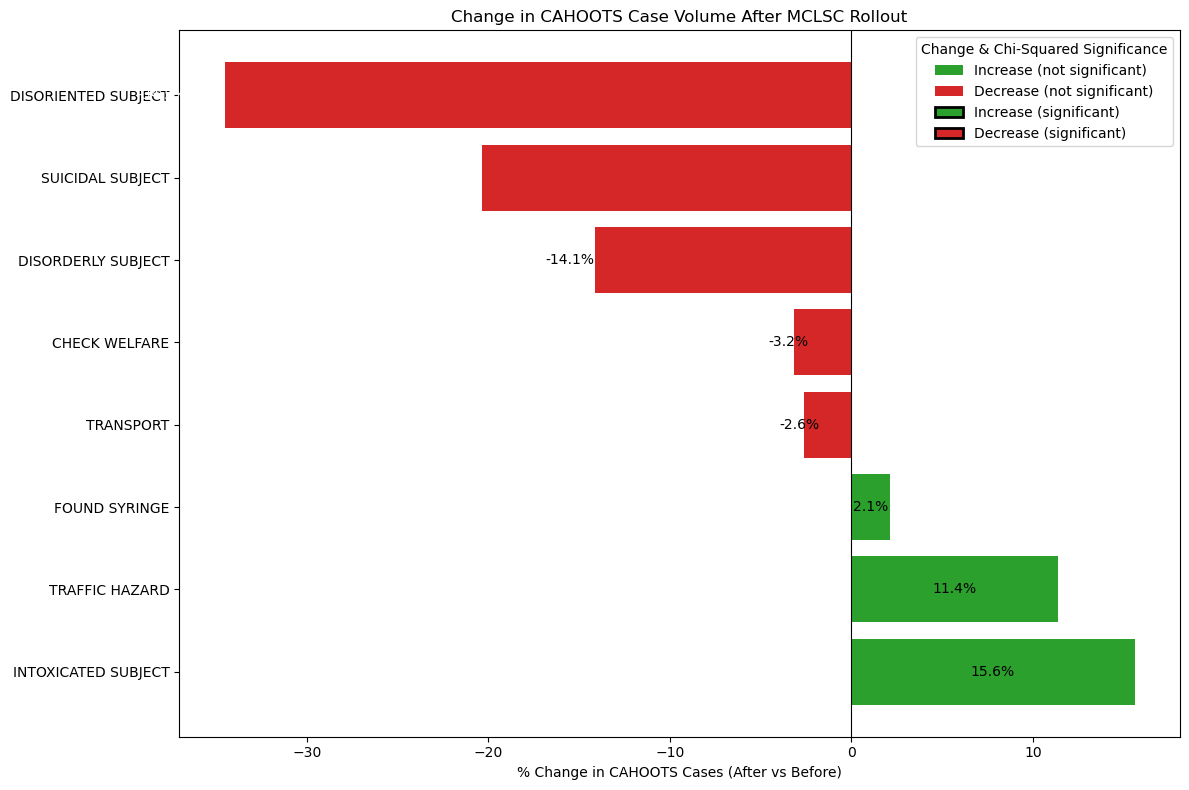

In [5]:
natures = merged_sorted["Nature"]
percent_change = merged_sorted["% Increase in CAHOOTS Cases"]
p_values = final_results["p-value"]
bar_colors = ['#2ca02c' if x >= 0 else '#d62728' for x in percent_change]
edge_colors = ['black' if p < 0.05 else 'none' for p in p_values]

significance = ['★' if p < 0.05 else '' for p in p_values]


sort_idx = np.argsort(percent_change)[::-1]
natures_sorted = natures.iloc[sort_idx].values
change_sorted = percent_change.iloc[sort_idx].values
sig_sorted = np.array(significance)[sort_idx]
bar_colors_sorted = np.array(bar_colors)[sort_idx]
edge_colors_sorted = np.array(edge_colors)[sort_idx]


plt.figure(figsize=(12, 8))
bars = plt.barh(
    natures_sorted,
    change_sorted,
    color=bar_colors_sorted,
    edgecolor=edge_colors_sorted,
    linewidth=2
)
for i, (change, sig) in enumerate(zip(change_sorted, sig_sorted)):
    if sig:
        plt.text(change, i, ' ' + sig,
                 va='center', ha='left' if change >= 0 else 'right',
                 color='gold', fontsize=14, weight='bold')
    plt.text(change/2 if change >= 0 else change*1.1, i,
             f'{change:.1f}%',
             va='center', ha='center',
             color='white' if abs(change) > 20 else 'black')

plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('% Change in CAHOOTS Cases (After vs Before)')
plt.title('Change in CAHOOTS Case Volume After MCLSC Rollout')

legend_elements = [
    Patch(facecolor='#2ca02c', edgecolor='none', label='Increase (not significant)'),
    Patch(facecolor='#d62728', edgecolor='none', label='Decrease (not significant)'),
    Patch(facecolor='#2ca02c', edgecolor='black', linewidth=2, label='Increase (significant)'),
    Patch(facecolor='#d62728', edgecolor='black', linewidth=2, label='Decrease (significant)')
]
plt.legend(handles=legend_elements, title='Change & Chi-Squared Significance', loc='upper right')

plt.tight_layout()
plt.show()


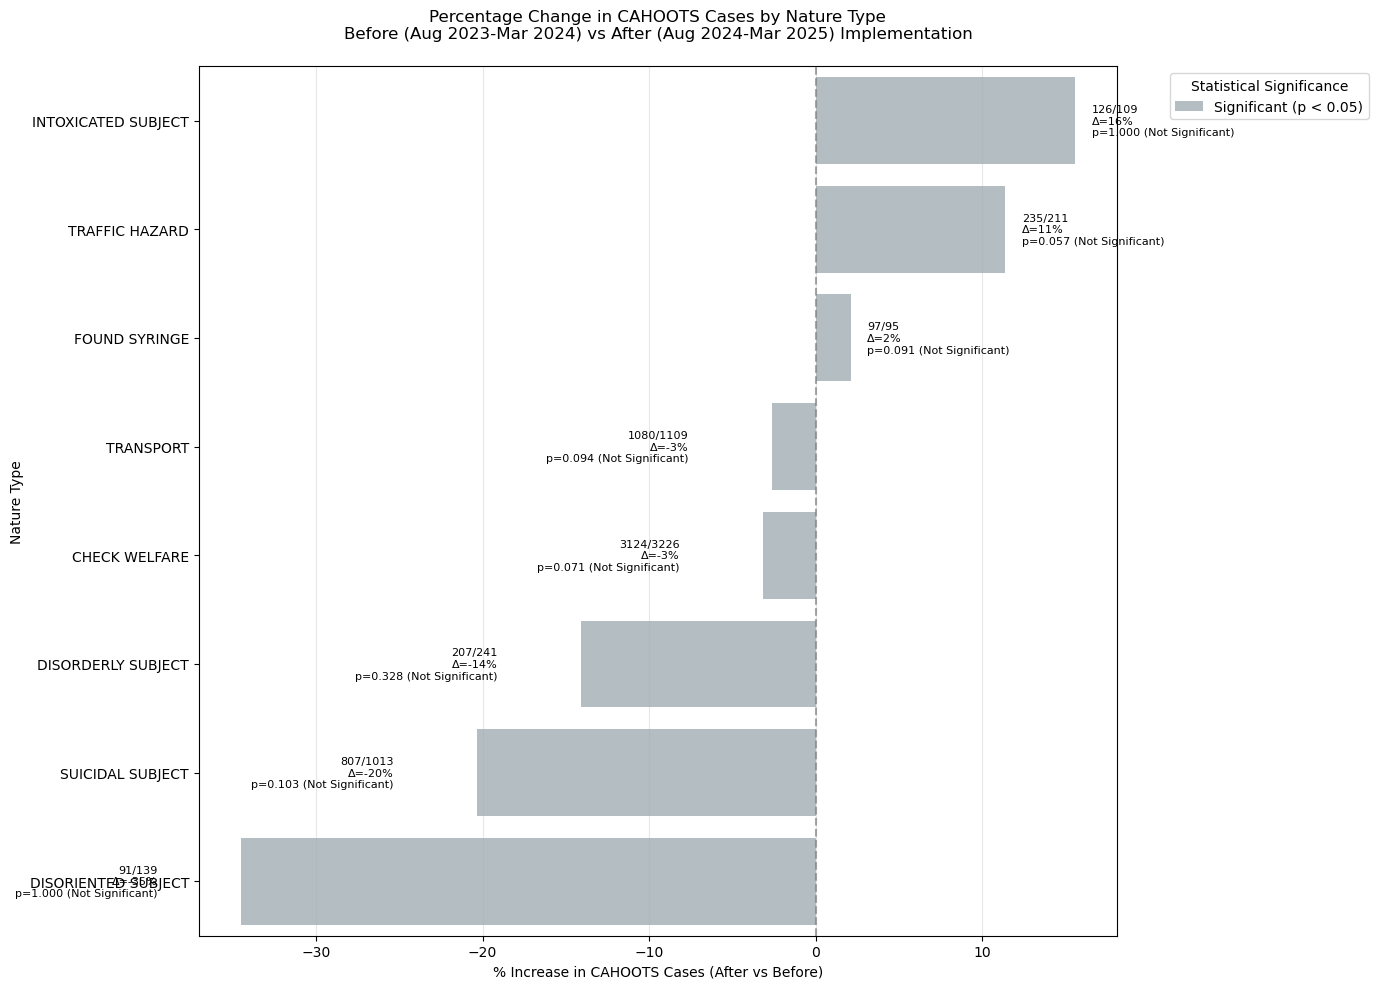

In [15]:
plot_df = final_results.sort_values("% Increase in CAHOOTS Cases", ascending=False).copy()
plot_df["Significance_Category"] = plot_df["p-value"].apply(
    lambda p: "Significant" if p < 0.05 else "Not Significant"
)

plot_df["Significance_Label"] = plot_df.apply(
    lambda row: f"p={row['p-value']:.3f} ({'Significant' if row['p-value'] < 0.05 else 'Not Significant'})", 
    axis=1
)

plot_df = plot_df[plot_df["% Increase in CAHOOTS Cases"] != float('inf')]

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=plot_df,
    x="% Increase in CAHOOTS Cases",
    y="Nature",
    hue="Significance_Category", 
    palette={"Significant": "#4CAF50", 
             "Not Significant": "#B0BEC5"},  
    dodge=False
)

for i, (_, row) in enumerate(plot_df.iterrows()):
    x_pos = row["% Increase in CAHOOTS Cases"] + 1 if row["% Increase in CAHOOTS Cases"] >= 0 else row["% Increase in CAHOOTS Cases"] - 5
    ha = 'left' if row["% Increase in CAHOOTS Cases"] >= 0 else 'right'
    
    case_text = f"{row['CAHOOTS Cases_After']}/{row['CAHOOTS Cases_Before']}"
    plt.text(x_pos, i, 
             f"{case_text}\nΔ={row['% Increase in CAHOOTS Cases']:.0f}%\n{row['Significance_Label']}", 
             va='center', fontsize=8, ha=ha)

plt.title("Percentage Change in CAHOOTS Cases by Nature Type\nBefore (Aug 2023-Mar 2024) vs After (Aug 2024-Mar 2025) Implementation", 
          pad=20, fontsize=12)
plt.xlabel("% Increase in CAHOOTS Cases (After vs Before)", fontsize=10)
plt.ylabel("Nature Type", fontsize=10)
plt.axvline(0, color="gray", linestyle="--", alpha=0.7)


handles, labels = ax.get_legend_handles_labels()
labels = ["Significant (p < 0.05)", "Not Significant (p ≥ 0.05)"]
plt.legend(handles, labels, title="Statistical Significance", 
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()


plt.show()

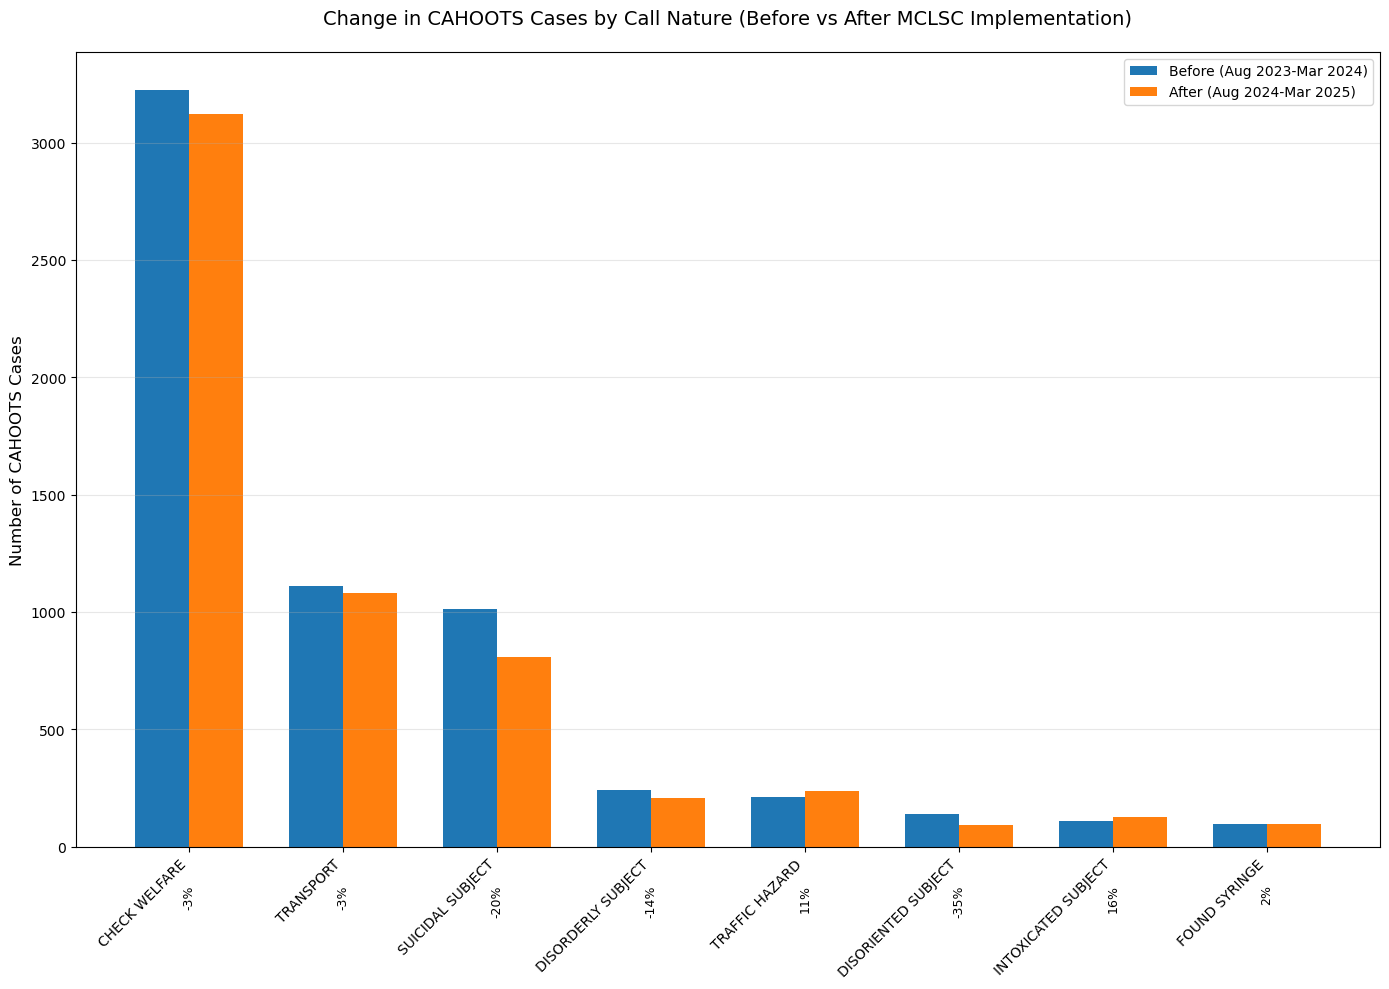

In [17]:
import matplotlib.pyplot as plt
import numpy as np


natures = final_results['Nature']
before_cases = final_results['CAHOOTS Cases_Before']
after_cases = final_results['CAHOOTS Cases_After']
p_values = final_results['p-value']
percent_increase = final_results['% Increase in CAHOOTS Cases']

sort_idx = np.argsort(before_cases)[::-1]
natures = natures.iloc[sort_idx]
before_cases = before_cases.iloc[sort_idx]
after_cases = after_cases.iloc[sort_idx]
p_values = p_values.iloc[sort_idx]
percent_increase = percent_increase.iloc[sort_idx]

plt.figure(figsize=(14, 10))

x = np.arange(len(natures))
width = 0.35

bars_before = plt.bar(x - width/2, before_cases, width, label='Before (Aug 2023-Mar 2024)', color='#1f77b4')
bars_after = plt.bar(x + width/2, after_cases, width, label='After (Aug 2024-Mar 2025)', color='#ff7f0e')

for i, (before, after, p) in enumerate(zip(before_cases, after_cases, p_values)):
    if p < 0.05:
        plt.text(x[i], max(before, after) + 5, '*', ha='center', fontsize=14, color='red')
    plt.text(x[i], -max(before_cases)*0.05, f'{percent_increase.iloc[i]:.0f}%', 
             ha='center', va='top', rotation=90, fontsize=9)

plt.ylabel('Number of CAHOOTS Cases', fontsize=12)
plt.title('Change in CAHOOTS Cases by Call Nature (Before vs After MCLSC Implementation)', fontsize=14, pad=20)
plt.xticks(x, natures, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


plt.show()

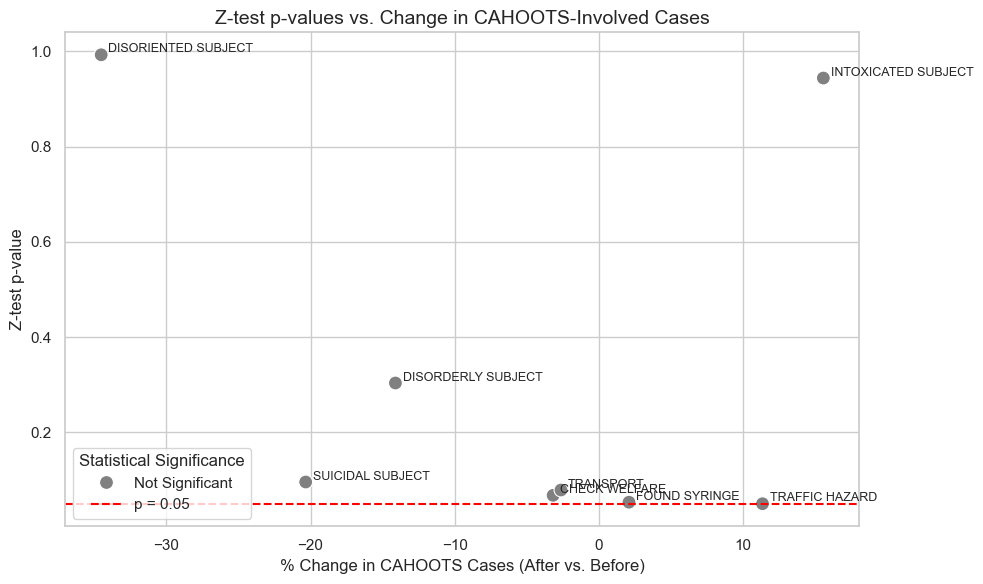

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = {
    'Nature': [
        'TRAFFIC HAZARD', 'CHECK WELFARE', 'FOUND SYRINGE', 'TRANSPORT',
        'SUICIDAL SUBJECT', 'DISORDERLY SUBJECT', 'INTOXICATED SUBJECT', 'DISORIENTED SUBJECT'
    ],
    '% Increase in CAHOOTS Cases': [
        11.374408, -3.161810, 2.105263, -2.614968,
        -20.335637, -14.107884, 15.596330, -34.532374
    ],
    'Z-test p-value': [
        0.0505, 0.0681, 0.0537, 0.0793,
        0.0961, 0.3039, 0.9440, 0.9928
    ]
}

df = pd.DataFrame(data)

df['Significance'] = df['Z-test p-value'].apply(
    lambda p: 'Significant (p < 0.05)' if p < 0.05 else 'Not Significant'
)

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

palette = {
    'Significant (p < 0.05)': 'green',
    'Not Significant': 'gray'
}

scatter = sns.scatterplot(
    data=df,
    x='% Increase in CAHOOTS Cases',
    y='Z-test p-value',
    hue='Significance',
    palette=palette,
    s=100
)

for i, row in df.iterrows():
    plt.text(
        row['% Increase in CAHOOTS Cases'] + 0.5,
        row['Z-test p-value'] + 0.005,
        row['Nature'],
        fontsize=9
    )

plt.axhline(y=0.05, color='red', linestyle='--', label='p = 0.05')

plt.title('Z-test p-values vs. Change in CAHOOTS-Involved Cases', fontsize=14)
plt.xlabel('% Change in CAHOOTS Cases (After vs. Before)', fontsize=12)
plt.ylabel('Z-test p-value', fontsize=12)
plt.legend(title='Statistical Significance', loc='lower left')

plt.tight_layout()
plt.show()
